In [1]:
!pip install yfinance
!pip install tensorflow

In [34]:
import yfinance as yf
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import mlflow
import mlflow.keras

In [12]:
#define the ticker symbol
tickerSymbol = 'TSM'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
dataset = tickerData.history(period='1d', start = '2000-1-1', end = '2022-9-3')

#see your data
dataset

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-12-31,8.861640,9.023667,8.836713,8.973812,428125,0.0,0.0
2000-01-03,9.422507,9.472361,9.185698,9.447433,2062807,0.0,0.0
2000-01-04,9.447431,9.821341,9.422504,9.509749,2557142,0.0,0.0
2000-01-05,9.596995,9.659313,9.509749,9.572068,2295467,0.0,0.0
2000-01-06,9.347722,9.360186,8.973813,9.173231,1539456,0.0,0.0
...,...,...,...,...,...,...,...
2022-08-29,83.910004,84.320000,82.779999,82.849998,9639700,0.0,0.0
2022-08-30,83.779999,83.980003,81.730003,82.790001,8392300,0.0,0.0
2022-08-31,84.110001,84.870003,83.059998,83.349998,8887100,0.0,0.0


In [13]:
dataset['Close'] = dataset['Close'].apply(pd.to_numeric)
train_test_split = 0.7

sc = MinMaxScaler(feature_range = (0, 1))
scaled_target = sc.fit_transform(dataset['Close'].values.reshape(-1, 1))
dataset['scaled_target'] = scaled_target

training_size = int(len(dataset) * train_test_split)
test_size= len(dataset) - training_size

dataset_train ,dataset_test = dataset.iloc[0:training_size, :],dataset.iloc[training_size:len(dataset), :]

In [14]:
training_set = dataset_train[['scaled_target']].values
training_set

array([[0.05009731],
       [0.05355066],
       [0.05400503],
       ...,
       [0.1190444 ],
       [0.11702096],
       [0.11493806]])

In [15]:
training_set.shape

(3994, 1)

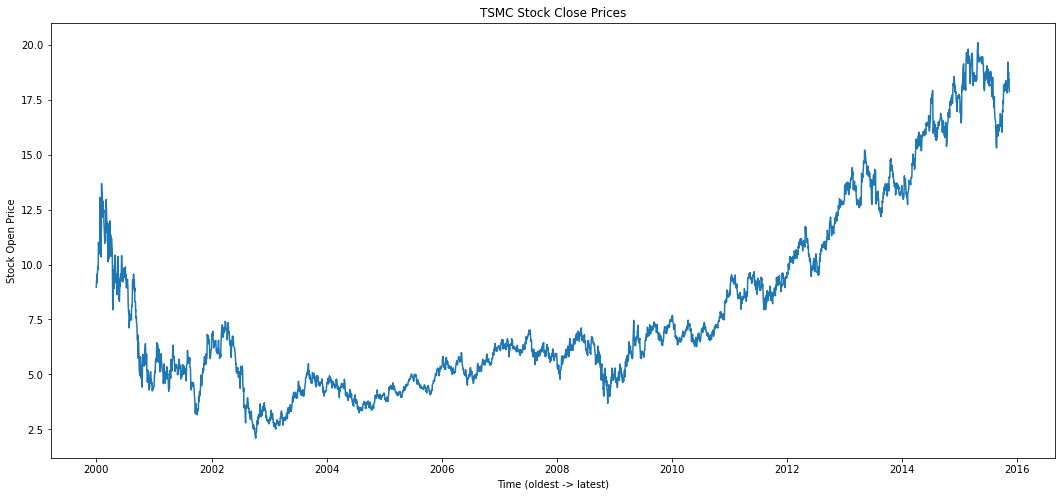

In [16]:
plt.figure(figsize=(18, 8))
plt.plot(dataset_train['Close'])
plt.title("TSMC Stock Close Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Open Price")
plt.show()

In [17]:
## 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set)):
    X_train.append(training_set[i-60: i, 0])
    y_train.append(training_set[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [18]:
print(X_train.shape)
print(y_train.shape)

(3934, 60)
(3934,)


In [19]:
X_train = np.reshape(X_train, newshape = 
                     (X_train.shape[0], X_train.shape[1], 1))

In [20]:
X_train.shape

(3934, 60, 1)

In [21]:
model = Sequential()
#add 1st lstm layer
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(rate = 0.2))

##add 2nd lstm layer: 50 neurons
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(rate = 0.2))

##add 3rd lstm layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(rate = 0.2))

##add 4th lstm layer
model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(rate = 0.2))

##add output layer
model.add(Dense(units = 1))

2022-09-05 10:31:43.124609: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-05 10:31:43.124661: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-05 10:31:43.124691: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (runtime-service-stock-prediction-example-67c8484f48-zk9zw): /proc/driver/nvidia/version does not exist
2022-09-05 10:31:43.127152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse', 'mae', 'mape'])

In [ ]:
model.summary()

In [24]:
lstm_model = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100, validation_split = 0.33)

Epoch 1/100
83/83 [==============================] - 19s 149ms/step - loss: 8.3530e-05 - mse: 8.3530e-05 - mae: 0.0066 - mape: 9182.2969 - val_loss: 8.0642e-05 - val_mse: 8.0642e-05 - val_mae: 0.0075 - val_mape: 8.8753
Epoch 2/100
83/83 [==============================] - 10s 123ms/step - loss: 1.9492e-05 - mse: 1.9492e-05 - mae: 0.0034 - mape: 118.4566 - val_loss: 1.9999e-04 - val_mse: 1.9999e-04 - val_mae: 0.0128 - val_mape: 15.6674
Epoch 3/100
83/83 [==============================] - 11s 128ms/step - loss: 1.7127e-05 - mse: 1.7127e-05 - mae: 0.0031 - mape: 1403.1144 - val_loss: 2.3522e-04 - val_mse: 2.3522e-04 - val_mae: 0.0135 - val_mape: 15.7559
Epoch 4/100
83/83 [==============================] - 10s 122ms/step - loss: 1.6486e-05 - mse: 1.6486e-05 - mae: 0.0031 - mape: 4081.1809 - val_loss: 5.2866e-05 - val_mse: 5.2866e-05 - val_mae: 0.0061 - val_mape: 7.4719
Epoch 5/100
83/83 [==============================] - 11s 133ms/step - loss: 1.3651e-05 - mse: 1.3651e-05 - mae: 0.0028 - ma

In [25]:
testing_set = dataset_test[['Close']].values
testing_set.shape

(1712, 1)

In [26]:
#vertical concat use 0, horizontal uses 1
dataset_total = pd.concat((dataset_train['scaled_target'], dataset_test['scaled_target']), 
                          axis = 0)
##use .values to make numpy array
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs

array([0.09702489, 0.09631076, 0.09631076, ..., 0.59240187, 0.57993362,
       0.57453802])

In [27]:
#reshape data to only have 1 col
inputs = inputs.reshape(-1, 1)

In [28]:
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
#add dimension of indicator
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [29]:
X_test.shape

(1712, 60, 1)

In [30]:
predicted_stock_price = model.predict(X_test)

54/54 [==============================] - 4s 29ms/step


In [31]:
#inverse the scaled value
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [32]:
predicted_stock_price

array([[17.193121],
       [17.270208],
       [17.429926],
       ...,
       [62.877396],
       [62.857388],
       [62.524403]], dtype=float32)

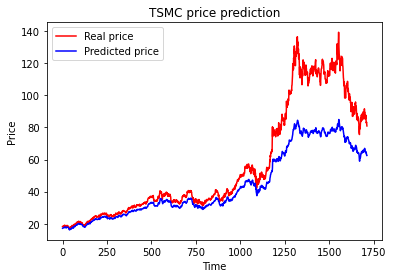

In [33]:
##visualize the prediction and real price
plt.plot(testing_set, color = 'red', label = 'Real price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')

plt.title('TSMC price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# need to get filling information from AI Maker(beta) > mlflow tracking
os.environ["AWS_ACCESS_KEY_ID"] = "{}" # need to fill
os.environ["AWS_SECRET_ACCESS_KEY"] = "{}" # need to fill
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://cloudstorage.oneai.twcc.ai"
os.environ["MLFLOW_TRACKING_URI"] = "{}" # need to fill

In [ ]:
with mlflow.start_run():
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse', 'mae', 'mape'])
    mlflow.keras.autolog()
    lstm_model = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100, validation_split = 0.33)

    mlflow.log_param("epochs", 100)
    mlflow.log_param("batch_size", 32)
    
    mlflow.set_tag("company", "TSMC")

    mlflow.keras.log_model(model, "models")